In [22]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb
import cv2

In [23]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Exercise 1: Binary image from original image
Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

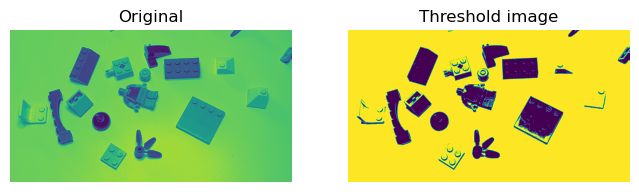

In [24]:
im_org = cv2.imread('lego_4_small.png', cv2.IMREAD_GRAYSCALE)
thresh = threshold_otsu(im_org)
ret, bin_img = cv2.threshold(im_org, thresh, 255, cv2.THRESH_BINARY)
show_comparison(im_org, bin_img, 'Threshold image')

## Exercise 2: Remove border BLOBs
Use segmentation.clear_border to remove border pixels from the binary image.

In [25]:
segmentation.clear_border(bin_img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Exercise 3: Cleaning using morphological operations
In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5.

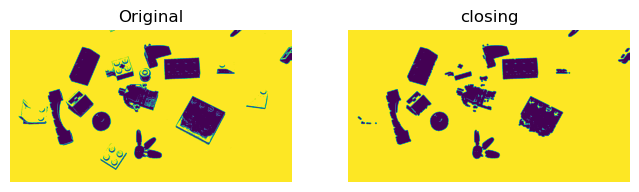

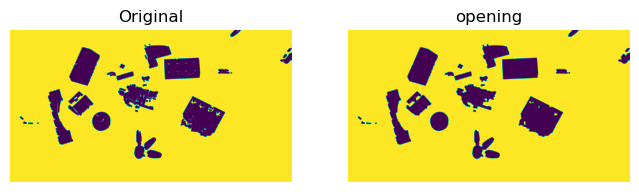

In [26]:
from skimage.morphology import erosion, dilation, opening, closing, disk

footprint = disk(5)

img_close = closing(bin_img, footprint)
show_comparison(bin_img, img_close, 'closing')

img_open = opening(img_close, footprint)
show_comparison(img_close, img_open, 'opening')

## Exercise 4: Find labels
The actual connected component analysis / BLOB analysis is performed using measure.label:

In [27]:
label_img = measure.label(img_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 8


## Exercise 5: Visualize found labels
We can use the function label2rbg to create a visualization of the found BLOBS. Show this together with the original image.

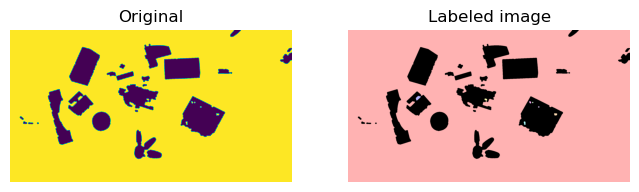

In [28]:
labeled_image = label2rgb(label_img, image=img_open, bg_label=0)
show_comparison(img_open, labeled_image, 'Labeled image')

## Exericse 6: Compute BLOB features
It is possible to compute a wide variety of BLOB features using the measure.regionprops function:

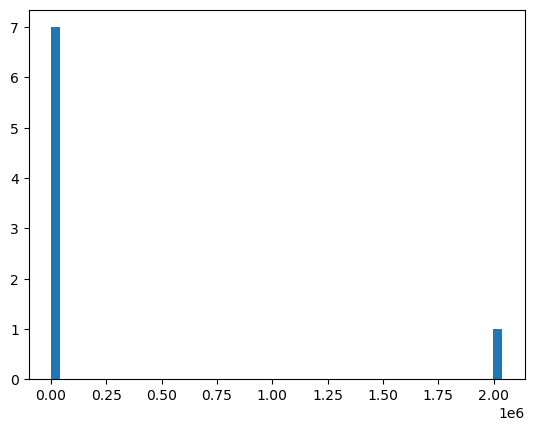

In [33]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

# Cell counting

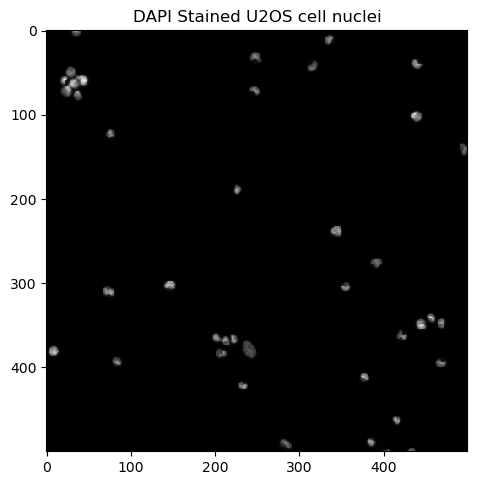

In [43]:
in_dir = "exercises/ex5-BLOBAnalysis/data/"
img_org = io.imread('Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

In [72]:
img_org.shape

(1440, 1920)

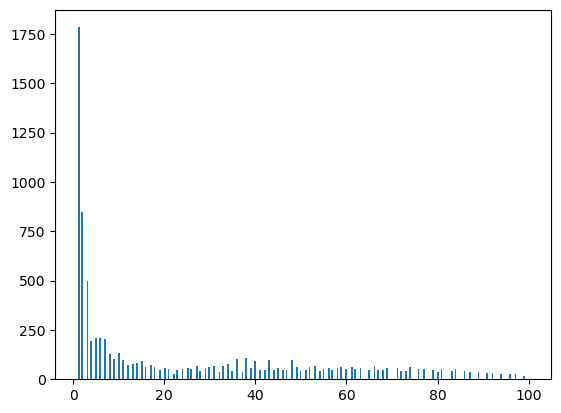

In [44]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

## Exercise 8: Threshold selection
Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

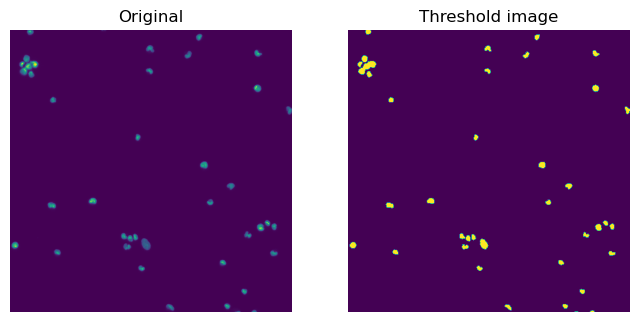

In [45]:
thresh = threshold_otsu(img_gray)
ret, img_c_b = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)
show_comparison(img_small, img_c_b, 'Threshold image')

## Exercise 9: Remove border BLOBS
Use segmentation.clear_border to remove border pixels from the binary image.

To be able to analyse the individual objects, the objects should be labelled.

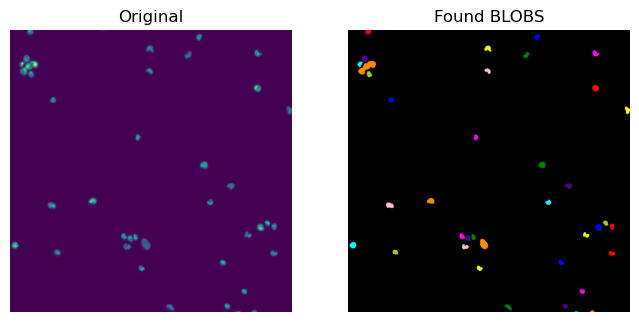

In [46]:
label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
show_comparison(img_small, image_label_overlay, 'Found BLOBS')

## Exercise 10: BLOB features
The task is now to find some object features that identify the cell nuclei and let us remove noise and connected nuclei. We use the function regionprops to compute a set of features for each object:

68


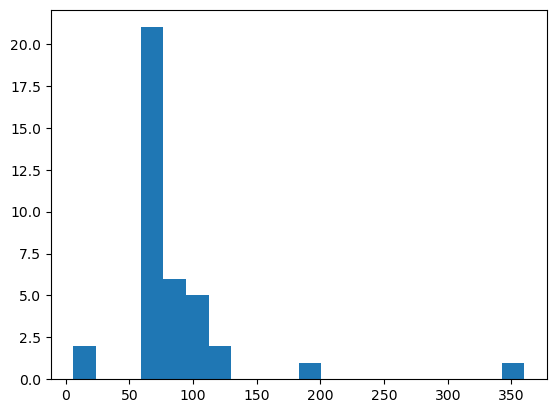

In [49]:
region_props = measure.regionprops(label_img)
print(region_props[0].area)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=20)
io.show()

## Exercise 11: BLOB classification by area
Select a minimum and maximum allowed area and use the following to visualise the result:

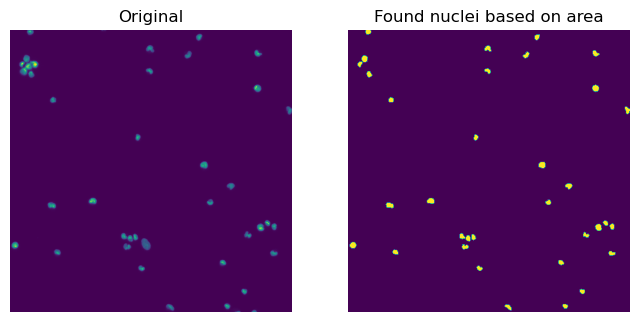

In [51]:
min_area = 50
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

## Exercise 12: Feature space
Extract all the perimeters of the BLOBS:

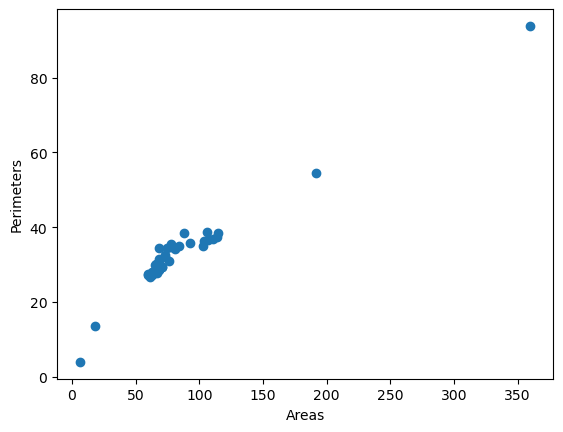

In [54]:
perimeters = np.array([prop.perimeter for prop in region_props])
plt.scatter(areas, perimeters)
plt.xlabel('Areas')
plt.ylabel('Perimeters')
io.show()

## Exercise 13: BLOB Circularity
We should also examine if the shape of the cells can identify them. Compute the circularity for all objects and plot a histogram.

Select some appropriate ranges of accepted circularity. Use these ranges to select only the cells with acceptable areas and circularity and show them in an image.

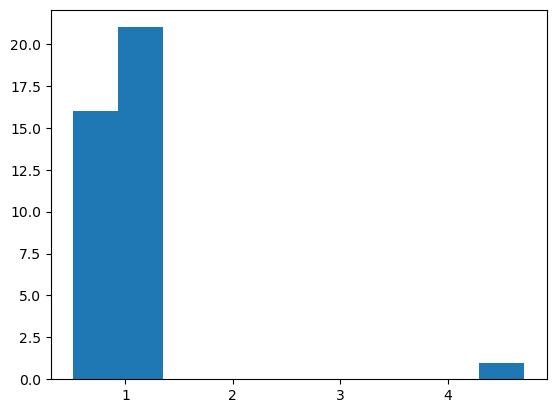

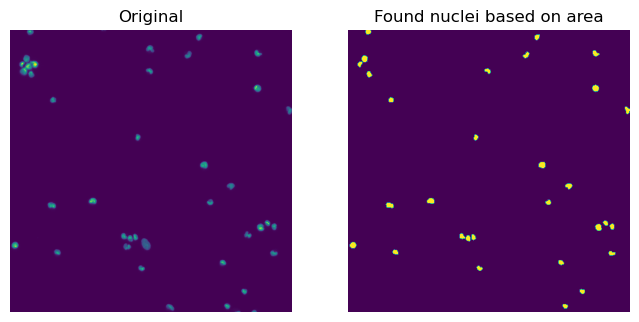

In [70]:
circularity = np.array([4*math.pi*areas[i]/perimeters[i]**2 for i in range(len(areas))])
plt.hist(circularity, bins=10)
io.show()
range_cir = 0.3
max_cir = 1 + range_cir
min_cir = 1 - range_cir
label_img_filter = label_img
for i in range(len(region_props)):
	# Find the areas that do not fit our criteria
	if circularity[i] > max_cir or circularity[i] < min_cir:
		# set the pixels in the invalid areas to background
		for cords in region_props[i].coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

## Exercise 14: BLOB circularity and area
Try to plot the areas versus the circularity. What do you observe?

Extend your method to return the number (the count) of well-formed nuclei in the image.

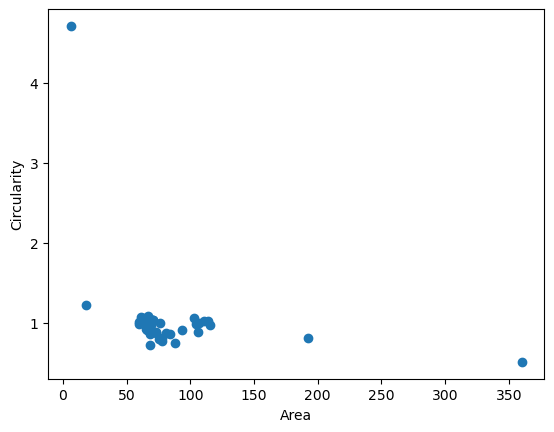

In [71]:
plt.scatter(areas, circularity)
plt.xlabel('Area')
plt.ylabel('Circularity')
io.show()